# Проект

## Основная идея

Представим, что мы являемся работниками в маленькой студии разработки игр $ SuperStrategiesGGame $. Наша студия планирует создать игру в жанре "стратегия" или "RPG" и выпустить в Steam, но, поскольку мы - инди-студия, на рекламе особо вывезти не получится. Поэтому, чтобы не попасть впросак, нам необходимо проанализировать рынок стратегий и RPG и выбрать оптимальный месяц выпуска игры (чтобы в большом количестве проектов наше творение не затерялось). Более того, нам необходимо понять, хорошо ли пользователи Steam относятся к жанру стратегий и RPG в целом. Мы сравним стратегии с жанром игр RPG и попробуем понять, выделяется ли один жанр на фоне другого. Если RPG будет выглядеть сильно предпочтительнее стратегии, то мы начнем разработку RPG. Если же нет, то создадим игру в нашем любимом стиле. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import requests
from bs4 import BeautifulSoup
import json
from threading import Lock
import re
import ast
from multiprocessing.dummy import Pool as ThreadPool
from scipy import stats

## Шаг 1. Сбор данных
Соберем информацию о последних 6000 играх-стратегиях и RPG, выпущенных в Steam. Нас будут интересовать только те игры, в которых количество отзывов >50. Игры с меньшим количеством отзывов мы будем просто учитывать как вышедшие, чтобы корректней спрогнозировать количество выпущенных игр в следующих месяцах.

In [2]:
months = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

In [3]:
lock = Lock()
#Multi Request
def multi_request(path, repeats=5, headers=None):
    for i in range(repeats):
        if headers is not None:
            req = requests.get(path, headers=headers)
        else:
            req = requests.get(path)
        if req.status_code // 100 == 2:
            break
    if req.status_code // 100 != 2:
        return None
    return req

In [4]:
def page_parser(ans):

    soup = BeautifulSoup(ans.text, 'html.parser')
    game_info = {
        'url': ans.url,
    }
    name = soup.find('div', class_="apphub_AppName")
    if name is not None:
        game_info['name'] = name.text
    votes = soup.find('div', class_='user_reviews_summary_row')
    if votes is not None:
        votes = votes.find('span', class_="nonresponsive_hidden responsive_reviewdesc")
        if votes is not None:
            votes = votes.text
            if not ("Need more user reviews to generate a score" in votes):
                percentage = re.search(r'([0-9]*\%)', votes)
                if percentage is not None:
                    game_info['pos_percentage'] = int(percentage.group()[:-1])
                v_count = re.search(r'[ ][0-9,]*[ ]', votes)
                if v_count is not None:
                    game_info['voters_count'] = int(v_count.group().replace(',', ''))
    date = soup.find('div', class_="release_date")
    if date is not None:
        date = date.find('div', class_="date")
        if date is not None:
            date = date.text
            if not ('soon' in date):
                date = date.replace(',', '').split()
                if len(date) == 3:
                    try:
                        game_info['date'] = f"{int(date[0])}-{months[date[1].lower()]}-{int(date[2])}"
                    except ValueError as e:
                        pass
                    except KeyError as e:
                        pass
                elif len(date) == 2:
                    try:
                        game_info['date'] = f"8-{months[date[0].lower()]}-{int(date[1])}"    
                    except KeyError as e:
                        pass
                    except ValueError as e:
                        pass
    return game_info

In [15]:
#URLS OF LATEST STRATEGIES
urls = []
for i in tqdm(range(0, 6000, 100)):
    ans = multi_request(f"https://store.steampowered.com/search/results/?query&start={i}&count={i+100}&dynamic_data=&sort_by=Released_DESC&tags=9&snr=1_7_7_240_7&infinite=1")
    answer = re.sub(r'\\', '', ans.text)
    urls += re.findall('"(https://store.steampowered.com/app.+?)"', answer)

In [5]:
#URLS OF LATEST RPGs
urls = []
for i in tqdm(range(0, 6000, 100)):
    ans = multi_request(f"https://store.steampowered.com/search/results/?query&start={i}&count={i+100}&dynamic_data=&sort_by=Released_DESC&force_infinite=1&tags=122&snr=1_7_7_240_7&infinite=1")
    answer = re.sub(r'\\', '', ans.text)
    urls += re.findall('"(https://store.steampowered.com/app.+?)"', answer)

100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


In [30]:
len(urls)

5995

In [17]:
#Processing all pages with multithreading

def proceed_page(url):
    if url is None:
        with lock:
            print('Url is incorrect', file=sys.stderr)
        return None
    ans = multi_request(url)
    if ans is None:
        with lock:
            print(f'Page cannot be reached with web-address: {url}')
        return None
    page = page_parser(ans)
    
    #require './jsons' folder. Uncomment if you have one and need to save .json files
    #try:
    #    with open('./jsons_rpg/' + page['name'].replace(' ', '_').replace('/','_') + '.json', 'w') as out:
    #        json.dump(page, out)
    #except Exception as e:
    #    pass
    return page

with ThreadPool(10) as pool:
    pages = pool.map(proceed_page, urls)

In [18]:
df = pd.DataFrame(columns = ['date', 'name', 'pos_percentage', 'voters_count', 'url'])

In [19]:
for page in pages:
    tmp_page = {}
    for i in page:
        if i in df.columns:
            tmp_page[i] = page[i]
    if 'date' in tmp_page:
        dates = tmp_page['date'].split('-')
        tmp_page['date'] = f"{dates[2]}-{dates[1].zfill(2)}-{dates[0].zfill(2)}"
        df = df.append(tmp_page, ignore_index=True)

In [31]:
df2 = df.sort_values(['date', 'voters_count'])
df2.head(10)

,Unnamed: 0,date,name,pos_percentage,voters_count,url
0,0,1985-06-01,Rogue,97.0,221.0,https://store.steampowered.com/app/1443430/Rog...
1,1,1986-07-01,Temple of Apshai Trilogy,NaN,NaN,https://store.steampowered.com/app/1436930/Tem...
2,2,1990-04-14,BatMUD,87.0,100.0,https://store.steampowered.com/app/616920/BatM...
3,3,1991-01-01,Planet's Edge,NaN,NaN,https://store.steampowered.com/app/1367170/Pla...
4,4,1991-06-01,Lost Patrol,NaN,NaN,https://store.steampowered.com/app/1392750/Los...
5,5,1993-01-01,The Legacy: Realm of Terror,NaN,NaN,https://store.steampowered.com/app/1257890/The...
6,6,1994-02-08,Xuan-Yuan Sword2,100.0,12.0,https://store.steampowered.com/app/1508740/Xua...
7,7,1995-01-06,Xuan-Yuan Sword: Dance of the Maple Leaves,95.0,91.0,https://store.steampowered.com/app/1508750/Xua...
8,8,1996-05-31,Sea Legends,NaN,NaN,https://store.steampowered.com/app/1373770/Sea...
9,9,1997-09-30,Have a N.I.C.E day!,NaN,NaN,https://store.steampowered.com/app/844940/Have...


In [21]:
df2.to_csv("rpg_info.csv", index=False)

## Шаг 2. Визуализация Данных
Выведем график количества выпущенных игр в зависимости от временного промежутка, а также общие графики отзывов

### Количество выпущенных игр
При визуализации не будем брать в учёт игры, выпущенные раньше 2018 года. Глобально ситуация 2010-2017 годов почти не отличается от 2018 года, но при этом из-за них график сжимается, и становится сложнее его просматривать.

In [2]:
df_rpg = pd.read_csv('./rpg_info2.csv').drop(columns=['url'])
df_str = pd.read_csv('./str_info2.csv').drop(columns=['url'])

In [3]:
df_rpg2 = df_rpg[(df_rpg.date > '2017-12-31') & (df_rpg.date < '2021-05-10')].reset_index(drop=True)
df_str2 = df_str[(df_str.date > '2017-12-31') & (df_str.date < '2021-05-10')].reset_index(drop=True)
df_rpg2.head(3)

,date,name,pos_percentage,voters_count
0,2018-02-01,Freeman: Guerrilla Warfare,91.0,82.0
1,2018-05-09,Tomscape,NaN,NaN
2,2018-06-06,Hakoniwa Explorer Plus,85.0,341.0


### Выпуск игр
Выведем информацию о количестве игр, выпущенных по месяцам

In [4]:
dates_rpg = df_rpg2['date']
dates_str = df_str2['date']
print(f"""
    Number of RPG games:      {dates_rpg.shape[0]} 
    Number of strategy games: {dates_str.shape[0]}
 """)


    Number of RPG games:      5477 
    Number of strategy games: 5533
 


In [5]:
def count_released_games(dates):
    counter = {}
    for ind, val in dates.items():
        if not (val[:7] in counter):
            counter[val[:7]] = 1
        else:
            counter[val[:7]] += 1
    return counter
rpg_counter = count_released_games(dates_rpg)
str_counter = count_released_games(dates_str)

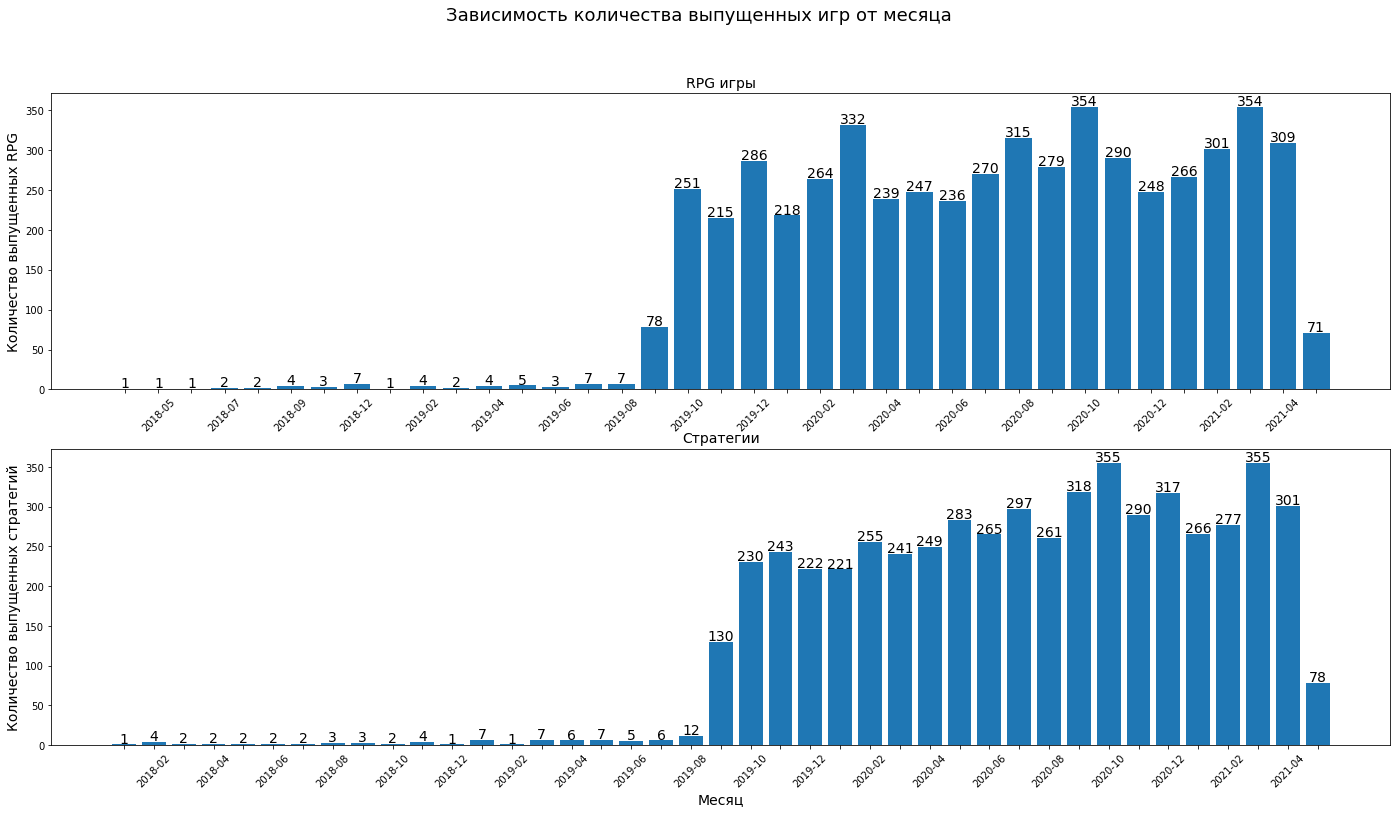

In [6]:
fig, ax = plt.subplots(nrows=2)
fig.suptitle("Зависимость количества выпущенных игр от месяца", fontsize=18)
fig.set_figheight(12)
fig.set_figwidth(24)

ax[0].bar(rpg_counter.keys(), list(rpg_counter.values()))
for label in ax[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
ax[0].set_ylabel('Количество выпущенных RPG', fontsize=14)
ax[0].set_title('RPG игры', fontsize=14)
for date, value in zip(rpg_counter.keys(), rpg_counter.values()):
    ax[0].text(date, value + 2, f"{value}", fontsize=14, horizontalalignment='center')

ax[1].bar(str_counter.keys(), list(str_counter.values()))
for label in ax[1].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
ax[1].set_xlabel('Месяц', fontsize=14)
ax[1].set_ylabel('Количество выпущенных стратегий', fontsize=14)
for date, value in zip(str_counter.keys(), str_counter.values()):
    ax[1].text(date, value + 2, f"{value}", fontsize=14, horizontalalignment='center')
_ = ax[1].set_title('Стратегии', fontsize=14)

Сразу отметим одну важную вещь: бум игр и дополнений к ним для обоих жанров произошел в конце 2019 года (когда как раз началась пандемия). Посмотрим теперь, какое количество игр за последние 3 года имели оценку в Steam и больше 50 отзывов.

In [7]:
df_rpg3 = df_rpg2.dropna(subset=['voters_count'])
df_rpg3 = df_rpg3[df_rpg3.voters_count > 50]
df_str3 = df_str2.dropna(subset=['voters_count'])
df_str3 = df_str3[df_str3.voters_count > 50]
print(f"""
    Number of rated RPG games:      {df_rpg3.shape[0]}
    Number of rated strategy games: {df_str3.shape[0]}
 """)


    Number of rated RPG games:      846
    Number of rated strategy games: 774
 


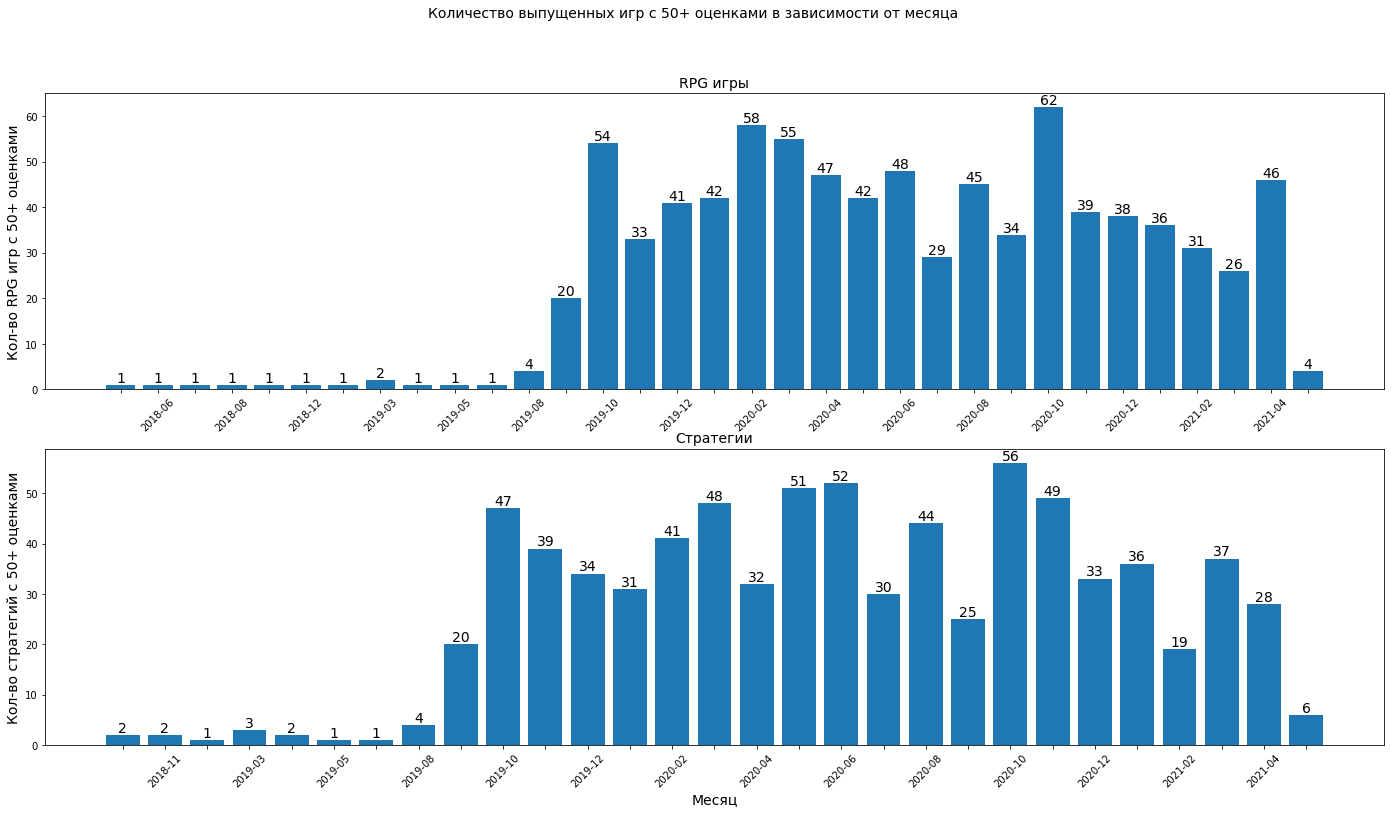

In [8]:
rpg_counter = count_released_games(df_rpg3['date'])
str_counter = count_released_games(df_str3['date'])

fig, ax = plt.subplots(nrows=2)
fig.suptitle("Количество выпущенных игр с 50+ оценками в зависимости от месяца", fontsize=14)
fig.set_figheight(12)
fig.set_figwidth(24)

ax[0].bar(rpg_counter.keys(), list(rpg_counter.values()))
for label in ax[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
ax[0].set_ylabel('Кол-во RPG игр с 50+ оценками', fontsize=14)
ax[0].set_title('RPG игры', fontsize=14)
for date, value in zip(rpg_counter.keys(), rpg_counter.values()):
    ax[0].text(date, value + 0.6, f"{value}", fontsize=14, horizontalalignment='center')

ax[1].bar(str_counter.keys(), list(str_counter.values()))
for label in ax[1].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
ax[1].set_xlabel('Месяц', fontsize=14)
ax[1].set_ylabel('Кол-во стратегий с 50+ оценками', fontsize=14)
for date, value in zip(str_counter.keys(), str_counter.values()):
    ax[1].text(date, value + 0.6, f"{value}", fontsize=14, horizontalalignment='center')
_ = ax[1].set_title('Стратегии', fontsize=14)

И вновь ситуация  довольно похожая. Отметим, что кол-во игр с 50+ отзывами уже гораздо меньше, чем в принципе выпущенных.

Оценим теперь количество высокооценных игр (не меньше 80% положительных отзывов) из оставшихся наборов и занесем все результаты в табличку.

In [9]:
df_rpg4 = df_rpg3.dropna(subset=['pos_percentage'])
df_rpg4 = df_rpg4[df_rpg4.pos_percentage >= 80]
df_str4 = df_str3.dropna(subset=['pos_percentage'])
df_str4 = df_str4[df_str4.pos_percentage >= 80]

In [10]:
Brief_info_df = pd.DataFrame(columns = ['N Released', 'N votes > 50', 'N score > 80%'])
Brief_info_df.loc[0] = [dates_rpg.shape[0], df_rpg3.shape[0], df_rpg4.shape[0]]
Brief_info_df.loc[1] = [dates_str.shape[0], df_str3.shape[0], df_str4.shape[0]]
Brief_info_df.index = ['RPG', 'Strategies']
Brief_info_df

,N Released,N votes > 50,N score > 80%
RPG,5477,846,495
Strategies,5533,774,421


Количество высокооцененных игр составляет менее 10% от всех, что говорит об избирательности пользователей. Некачественно сделанный проект подвергнется суровой критике и не будет принят публикой. 

## Шаг 3. Гипотезы
Проверим мы две гипотезы: 

1) В период COVID-19 (официально с 1 декабря 2019 года) количество игр не увеличилось.

2) RPG игры имеют больший интерес и отклик у пользователей Steam, чем стратегии. В таком случае мы будем делать RPG игру, чтобы получить больше прибыли. Иначе выберем                                стратегию, так как это наиболее привычный и удобный жанр для нашей студии

### Гипотеза 1.
Оценим первую гипотезу с помощью средних значений и стандартного отклонения. Для старых игр возьмем зеркально информацию об играх за последние 2,5 года с момента 1 декабря 2019 года, чтобы уравновесить наборы по временным промежуткам. Для новых игр уберем май, апрель и март 2021 года, так как за маленький промежуток времени отзывы могли не успеть накопиться.

In [11]:
df_rpg = pd.read_csv('./rpg_info2.csv').drop(columns=['url', 'name'])
df_str = pd.read_csv('./str_info2.csv').drop(columns=['url', 'name'])

In [12]:
df_rpg_old = df_rpg[(df_rpg.date < '2019-12-01') & (df_rpg.date >='2017-08-01')]
df_rpg_new = df_rpg[(df_rpg.date >= '2019-12-01') & (df_rpg.date < '2021-03-01')]
df_str_old = df_str[(df_str.date < '2019-12-01') & (df_str.date >='2017-08-01')]
df_str_new = df_str[(df_str.date >= '2019-12-01') & (df_str.date < '2021-03-01')]


In [13]:
def count_released_games(dates):
    counter = {}
    for ind, val in dates.items():
        if not (val[:7] in counter):
            counter[val[:7]] = 1
        else:
            counter[val[:7]] += 1
    return counter
rpg_old_votes = list(count_released_games(df_rpg_old['date']).values())
rpg_new_votes = list(count_released_games(df_rpg_new['date']).values())
str_old_votes = list(count_released_games(df_str_old['date']).values())
str_new_votes = list(count_released_games(df_str_new['date']).values())

In [14]:
print(rpg_new_votes, rpg_old_votes, sep='\n')
print('-----------------')
print(str_new_votes, str_old_votes, sep='\n')

[286, 218, 264, 332, 239, 247, 236, 270, 315, 279, 354, 290, 248, 266, 301]
[4, 1, 2, 1, 1, 1, 2, 2, 4, 3, 7, 1, 4, 2, 4, 5, 3, 7, 7, 78, 251, 215]
-----------------
[222, 221, 255, 241, 249, 283, 265, 297, 261, 318, 355, 290, 317, 266, 277]
[1, 1, 2, 1, 1, 4, 2, 2, 2, 2, 2, 3, 3, 2, 4, 1, 7, 1, 7, 6, 7, 5, 6, 12, 130, 230, 243]


Даже без построения графиков разница кажется довольно заметной:)

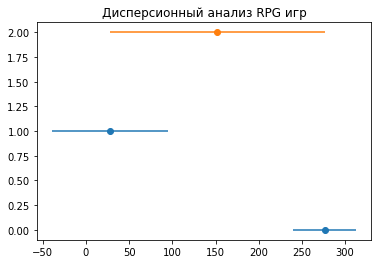

In [15]:
means = np.asarray([np.mean(rpg_new_votes), np.mean(rpg_old_votes)])
y = np.arange(2)
stds = np.asarray([np.std(rpg_new_votes), np.std(rpg_old_votes)])

plt.errorbar(means, y, xerr = stds, linestyle='None', marker='o')
plt.errorbar( np.mean(means), y.shape[0] ,xerr =  np.std(means), linestyle='None', marker='o')
_ = plt.title('Дисперсионный анализ RPG игр')

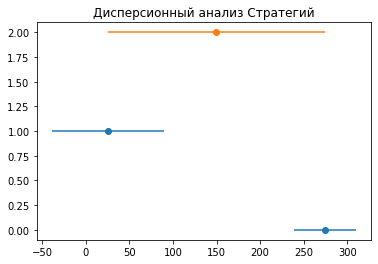

In [16]:
means = np.asarray([np.mean(str_new_votes), np.mean(str_old_votes)])
y = np.arange(2)
stds = np.asarray([np.std(str_new_votes), np.std(str_old_votes)])

plt.errorbar(means, y, xerr = stds, linestyle='None', marker='o')
plt.errorbar( np.mean(means), y.shape[0] ,xerr =  np.std(means), linestyle='None', marker='o')
_ = plt.title('Дисперсионный анализ Стратегий')

Группы сильно уверенны в себе по сравнению с разбросом средних. Разброс средних огромный -> вероятность того, что наши группы (игр, выпущенных до и после пандемии) принадлежат одной совокупности крайне мала.

In [17]:
F_str, p_str = stats.f_oneway(str_new_votes, str_old_votes)
F_rpg, p_rpg = stats.f_oneway(rpg_new_votes, rpg_old_votes)
print(f"""
Strategies: F = {F_str:.2f}, p = {p_str}
RPG:        F = {F_rpg:.2f}, p = {p_rpg}
""")


Strategies: F = 182.64, p = 1.6904355824749132e-16
RPG:        F = 162.62, p = 1.0249322185009762e-14



p - крайне мало -> мы можем отвергнуть гипотезу о том, что пандемия не повлияла на количество выпускаемых проектов.

### Гипотеза 2.

Мы имеем две несвязанные выборки и предположение о том, что один жанр оценивается лучше другого. Для начала найдем количество положительных отзывов за каждый месяц. Для этого нам понадобится немного допредобработать наш датасет. После этого построим гипотезу с помощью критерия Манна-Уитни. Возьмем +- новые проекты (всё, что было выпущено после 2016 года).

In [18]:
df_rpg = pd.read_csv('./rpg_info2.csv').drop(columns=['url', 'name'])
df_str = pd.read_csv('./str_info2.csv').drop(columns=['url', 'name'])

In [19]:
# Возьмем в этот раз игры от 2016 года выпуска (не очень старые игры), чтобы посмотреть как более глобальную картину
df_rpg = df_rpg[df_rpg.date >='2016-01-01'].dropna(subset=['pos_percentage', 'voters_count'])
df_str = df_str[df_str.date >='2016-01-01'].dropna(subset=['pos_percentage', 'voters_count'])

In [20]:
def count_positive_votes(df):
    '''
    returns dict object where keys - year-month strings
                              values - number of positive votes during the key year-month
    '''
    dates = {}
    for ind, row in df.iterrows():
        if row['date'][:7] in dates:
            dates[row['date'][:7]] += int(row['voters_count'] * row['pos_percentage'] / 100)
        else:
            dates[row['date'][:7]] = int(row['voters_count'] * row['pos_percentage'] / 100)
    return dates


rpg_pos_votes = count_positive_votes(df_rpg)
str_pos_votes = count_positive_votes(df_str)

In [21]:
rpg_pos_votes_val = sorted(list(rpg_pos_votes.values()))
str_pos_votes_val = sorted(list(str_pos_votes.values()))

In [22]:
stats.mannwhitneyu(str_pos_votes_val, rpg_pos_votes_val, alternative='less')

MannwhitneyuResult(statistic=832.5, pvalue=0.3305597336841024)

p = 0.33 -> мы не можем отвергнуть гипотезу, но и принять альтернативную гипотезу мы также не можем. Поэтому мы не будем разрабатывать RPG игру, так как это статистически не оправдано. Воспользуемся теперь критерием Стюдьента, чтобы закрепить нашу догадку.

In [23]:
stats.ttest_ind(str_pos_votes_val, rpg_pos_votes_val)

Ttest_indResult(statistic=-0.9899230675831711, pvalue=0.32512383909185694)

Опять-таки мы получили p = 0.32, из-за чего мы не можем гарантировать себе, что при разработке более сложной для нас RPG игры мы реализуем игру в жанре, который больше ценится среди игроков.

## Шаг 4. Временной ряд
Итак, мы определились с жанром игры. Попробуем теперь составить временной ряд и предсказать количество релизов на следующие месяцы (включая май 2021), чтобы понять, в каком месяце количество конкурентных проектов будет минимальным

In [24]:
df_str = pd.read_csv('./str_info2.csv').drop(columns=['url', 'name'])
df_str2 = df_str[(df_str.date > '2015-12-31') & (df_str.date < '2021-05-01')].reset_index(drop=True)
dates_str = df_str2['date']

In [25]:
def count_released_games(dates):
    counter = {}
    for ind, val in dates.items():
        if not (val[:7] in counter):
            counter[val[:7]] = 1
        else:
            counter[val[:7]] += 1
    for i in range(1, 13):
        for j in range(2016, 2021):
            cur_month = f"{j}-{str(i).zfill(2)}"
            if not(cur_month in counter):
                counter[cur_month] = 0
    output_counter = {}
    for key in sorted(counter.keys()):
        output_counter[key] = counter[key]
    return output_counter
str_counter = count_released_games(dates_str)

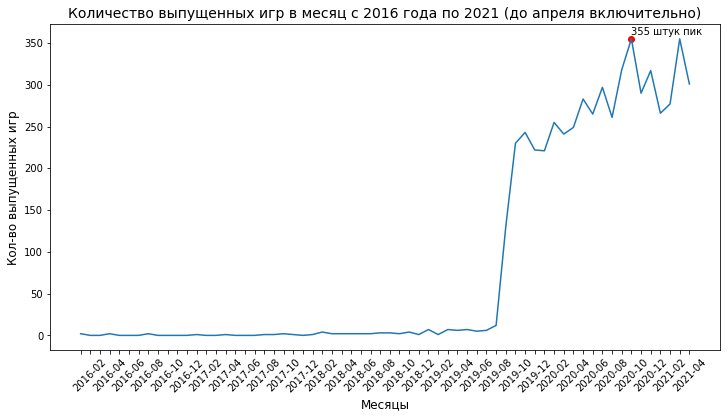

In [26]:
quantities = list(str_counter.values())
dates = list(str_counter.keys())
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
ax.plot(dates, quantities)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
_ = plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.scatter(dates[np.argmax(quantities)], np.max(quantities), c='red')
plt.title("Количество выпущенных игр в месяц с 2016 года по 2021 (до апреля включительно)", fontsize=14)
plt.xlabel("Месяцы", fontsize=12)
plt.ylabel("Кол-во выпущенных игр", fontsize=12)
_ = plt.text(dates[np.argmax(quantities)], np.max(quantities) + 5, f"{np.max(quantities)} штук пик")

Построим теперь предсказание временного ряда с помощью Холта

In [27]:
fit = Holt(quantities).fit(smoothing_level=0.35)
next_months = fit.forecast(20) # до декабря следующего года включительно

/home/dmitrii/anaconda3/envs/sphere/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [28]:
next_months

array([311.44853106, 312.04168911, 312.63484716, 313.22800521,
       313.82116325, 314.4143213 , 315.00747935, 315.6006374 ,
       316.19379545, 316.78695349, 317.38011154, 317.97326959,
       318.56642764, 319.15958569, 319.75274374, 320.34590178,
       320.93905983, 321.53221788, 322.12537593, 322.71853398])

Предсказание ряда говорит нам о том, что в будущем ожидается только рост ежемясчного выпуска игр в жанре "Стратегия". Значит, нам необходимо сделать игру в кратчайшие сроки, чтобы обеспечить себе наименьшую конкуренцию и больший спрос на наш товар (после окончания пандемии, исходя из наших исследований, кол-во покупок и отзывов должно пойти на спад).

## Шаг 6. Заключение
Мы провели анализ рынка игр в жанре "стратегия" и "RPG", используя выпущенные игры в Steam. Для себя мы смогли определить следующие важные особенности, которые могут повлиять на нашу разработку:

1) Количество выпущенных игр (и дополнений) сильно превосходит количество игр, имеющих много отзывов. Более того, "хороших" игр по мнению пользователей крайне мало по сравнению с общим объемом, что говорит о том, что покупатели довольно привередливы и не готовы платить деньги за некачественный продукт.

2) Пандемия оказала сильное влияние на игроделов и игроков, из-за чего нам, как маленькой компании без особой рекламы, выгодно в кратчайшие сроки сделать игру, чтобы успеть до окончания COVID-19, который заставляет людей оставаться дома и проявлять больший интерес к платформе Steam и играм на ней.

3) Мы - компания, которая специализируется на играх-стратегиях. Статистический анализ не показал, что создание игры в жанре RPG имеет больший потенциал, чем создание стратегии. Из-за этого нам следует остаться в привычных условиях и сделать стратегию.

4) Steam не против того, чтобы его обкачивали много-много раз, поэтому для возможных дальнейших исследований он является очень хорошим кандидатом:)